In [1]:
from transformers import AutoConfig,AutoTokenizer,AutoModelForSequenceClassification,DefaultDataCollator
import datasets
import torch
from transformers.utils import PaddingStrategy
from torch.utils.data import DataLoader,WeightedRandomSampler
from argparse import Namespace
from sklearn.utils.class_weight import compute_class_weight
from peft import PeftModel,AdaLoraConfig,TaskType,get_peft_model
import pandas as pd
from collections import defaultdict
from datetime import datetime
from typing import Any, Callable, Dict, List, NewType, Optional, Tuple, Union
from finglm.utils import load_data,load_data_all
import warnings
warnings.filterwarnings("ignore")
today =datetime.today().strftime("%Y%m%d_%H%M%S")
cfg = Namespace()
cfg.prompt_column = "prompt"
cfg.label_column = "response"
cfg.prefix = ""
cfg.source_length = 70
cfg.target_length = 70
cfg.device = "cuda:0"
cfg.LABEL_MAPPING = {
        "强烈不推荐": [0],
        "不推荐":[1],
        "一般":[2],
        "推荐":[3],
        "强烈推荐":[4],
    }




cfg.gradient_accumulation_steps = 500
cfg.epochs = 10
cfg.batch_size = 4
cfg.lr = 1e-4
cfg.scheduler_gamma = 0.5


cfg.target_modules = ["query_key_value"]

cfg.year = 2022
cfg.read_ckpt_path = f"/root/autodl-tmp/glm-finetune/finglm/five_year_data/20231107_104611"
cfg.save_ckpt_path = f"/root/autodl-tmp/glm-finetune/finglm/five_year_data/{today}"



In [2]:
model_path = "/root/autodl-tmp/models/chatglm3-6b"
num_labels = 5
problem_type = "single_label_classification"
classifier_dropout = 0.2
tokenizer = AutoTokenizer.from_pretrained(model_path,trust_remote_code = True)
config = AutoConfig.from_pretrained(model_path,trust_remote_code = True)
config.num_labels = num_labels
config.problem_type = problem_type
config.classifier_dropout = classifier_dropout
config.output_hidden_states = True
config.add_bias_linear = True





In [3]:
## load_data
df = load_data_all([i for i in range(2017,cfg.year+1)])
df = df[['month','year','prompt','response']]
df.dropna(inplace = True)

train_df = df.query("year == 2022 and month < 12")
val_df = df.query("year == 2022 and month == 12")

train_ds = datasets.Dataset.from_pandas(train_df)
val_ds = datasets.Dataset.from_pandas(val_df)

cfg.scheduler_steps = len(train_ds)//cfg.gradient_accumulation_steps

In [4]:
def multi_label_preprocess(examples,tokenizer,cfg)->Dict[str,Any]:
    model_inputs = {
        "input_ids": [],
        "attention_mask": [],
        "position_ids": [],
        "labels": []
    }
    max_length = cfg.source_length + cfg.target_length
    prefix = cfg.prefix
    for idx in range(len(examples[cfg.prompt_column])):
        if examples[cfg.prompt_column][idx] and examples[cfg.label_column][idx]:
            prompt,label = examples[cfg.prompt_column][idx],examples[cfg.label_column][idx]
            prompt = prefix+prompt
            input_ids = tokenizer.build_single_message("observation","",prompt)
            #input_ids = tokenizer.build_inputs_with_special_tokens(input_ids)
            input_ids = input_ids + [tokenizer.eos_token_id]
            encoded_inputs = tokenizer.encode_plus(input_ids,is_split_into_words = True)
            padded_encoded_inputs = tokenizer._pad(encoded_inputs,max_length=max_length,padding_strategy = PaddingStrategy.MAX_LENGTH, return_attention_mask = True)
            model_inputs["input_ids"].append(padded_encoded_inputs["input_ids"])
            model_inputs["attention_mask"].append(padded_encoded_inputs["attention_mask"])
            model_inputs["position_ids"].append(padded_encoded_inputs["position_ids"])
            model_inputs["labels"].append(cfg.LABEL_MAPPING[label])
    return model_inputs



def weighted_sampler(df: pd.DataFrame,cfg) -> Tuple[Dict[int,float],WeightedRandomSampler]:
    classes = df[cfg.label_column].unique()
    class_weight = compute_class_weight("balanced",classes=classes, y = df[cfg.label_column].values)
    label_weight = defaultdict()
    for class_label,weight in zip(classes,class_weight):
        label_weight[cfg.LABEL_MAPPING[class_label][0]] = weight
    sampler = WeightedRandomSampler(weights=torch.tensor([label_weight[cfg.LABEL_MAPPING[class_label][0]] for class_label in df[cfg.label_column].values]).to(cfg.device),num_samples = len(df[cfg.label_column].values),replacement = True)
    return label_weight,sampler
        
    



In [5]:
train_model_inputs = train_ds.map(multi_label_preprocess,batched = True,num_proc=8,remove_columns = train_ds.column_names,fn_kwargs={"tokenizer":tokenizer,"cfg":cfg})
val_model_inputs = val_ds.map(multi_label_preprocess,batched = True,num_proc=8,remove_columns = val_ds.column_names,fn_kwargs={"tokenizer":tokenizer,"cfg":cfg})
collate_fn =  DefaultDataCollator(return_tensors = 'pt')
label_weight,sampler = weighted_sampler(train_df,cfg)
train_dl = DataLoader(train_model_inputs,batch_size = cfg.batch_size,collate_fn = collate_fn,sampler = sampler)
val_dl = DataLoader(val_model_inputs,batch_size=cfg.batch_size,collate_fn=collate_fn,shuffle=False)

config.label_weight = label_weight

Map (num_proc=8):   0%|          | 0/31051 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/1064 [00:00<?, ? examples/s]

In [6]:
##PEFT settings
adalora = AdaLoraConfig(
    task_type = TaskType.SEQ_CLS,
    target_modules=cfg.target_modules,
    init_r=12,
    target_r=0,
    beta1=0.85,
    beta2=0.85,
    tinit=200,
    tfinal=1000,
    deltaT=10,
    lora_alpha=32,
    lora_dropout=0.2,
    inference_mode=False
)
model = AutoModelForSequenceClassification.from_pretrained(model_path,config = config,trust_remote_code = True,torch_dtype=torch.float16).cuda()
model = PeftModel.from_pretrained(model,cfg.read_ckpt_path,is_trainable = True).cuda() # 添加is_trainable=True使LoRA参数参与训练
#model = model.merge_and_unload() #与之前训练的LoRA权重融合
#model = get_peft_model(model,adalora) # 添加新的LoRA块

#model.classifier_head.load_state_dict(torch.load(f'{cfg.read_ckpt_path}/classifier_head.bin')) # 加载之前训练的classifier_head的参数

print(f"Modle Config:")
print(model.config)
print("="*100)
print("LoRA Module:")
model.print_trainable_parameters()
print("="*100)

def enable_trainable_module(model,names: List[str])->None:
    for module_name,params in model.named_parameters():
        for name in names:
            if name in names.split('.'):
                params.requires_grad = True
                params.data = params.data.float()

for parameter in model.classifier_head.parameters(): 
    parameter.requires_grad = True # classifier_head的weight和bias参数参与梯度计算
    parameter.data = parameter.data.float() # 转换为 torch.float32，否则梯度计算会报ValueError: Attempting to unscale FP16 gradients.
print("With Classifier Head:")
model.print_trainable_parameters()

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

Some weights of ChatGLMForSequenceClassification were not initialized from the model checkpoint at /root/autodl-tmp/models/chatglm3-6b and are newly initialized: ['transformer.encoder.layers.20.self_attention.dense.bias', 'transformer.encoder.layers.24.self_attention.dense.bias', 'transformer.encoder.layers.22.mlp.dense_h_to_4h.bias', 'transformer.encoder.layers.7.mlp.dense_h_to_4h.bias', 'transformer.encoder.layers.27.mlp.dense_h_to_4h.bias', 'transformer.encoder.layers.21.self_attention.dense.bias', 'classifier_head.weight', 'transformer.encoder.layers.27.mlp.dense_4h_to_h.bias', 'transformer.encoder.layers.25.mlp.dense_4h_to_h.bias', 'transformer.encoder.layers.5.mlp.dense_4h_to_h.bias', 'transformer.encoder.layers.14.self_attention.dense.bias', 'transformer.encoder.layers.20.mlp.dense_4h_to_h.bias', 'transformer.encoder.layers.8.mlp.dense_h_to_4h.bias', 'transformer.encoder.layers.27.self_attention.dense.bias', 'transformer.encoder.layers.24.mlp.dense_4h_to_h.bias', 'transformer.en

Modle Config:
ChatGLMConfig {
  "_name_or_path": "/root/autodl-tmp/models/chatglm3-6b",
  "add_bias_linear": true,
  "add_qkv_bias": true,
  "apply_query_key_layer_scaling": true,
  "apply_residual_connection_post_layernorm": false,
  "architectures": [
    "ChatGLMModel"
  ],
  "attention_dropout": 0.0,
  "attention_softmax_in_fp32": true,
  "auto_map": {
    "AutoConfig": "configuration_chatglm.ChatGLMConfig",
    "AutoModel": "modeling_chatglm.ChatGLMForConditionalGeneration",
    "AutoModelForCausalLM": "modeling_chatglm.ChatGLMForConditionalGeneration",
    "AutoModelForSeq2SeqLM": "modeling_chatglm.ChatGLMForConditionalGeneration",
    "AutoModelForSequenceClassification": "modeling_chatglm.ChatGLMForSequenceClassification"
  },
  "bias_dropout_fusion": true,
  "classifier_dropout": 0.2,
  "eos_token_id": 2,
  "ffn_hidden_size": 13696,
  "fp32_residual_connection": false,
  "hidden_dropout": 0.0,
  "hidden_size": 4096,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "

In [7]:

## config.is_add_bias = True后，MLP,dense层的bias会出现nan值，这里重新设置为0，否则loss会变成nan

for i in range(28):
    self_attention_dense_bias = model.base_model.model.transformer.encoder.layers[i].self_attention.dense.bias.data
    
    dense_h_to_4h_bias = model.base_model.model.transformer.encoder.layers[i].mlp.dense_h_to_4h.bias.data
    dense_4h_to_h_bias = model.base_model.model.transformer.encoder.layers[i].mlp.dense_4h_to_h.bias.data
    
    model.base_model.model.transformer.encoder.layers[i].self_attention.dense.bias.data = torch.zeros(self_attention_dense_bias.shape,device = self_attention_dense_bias.device,dtype=torch.float16 )
    model.base_model.model.transformer.encoder.layers[i].mlp.dense_h_to_4h.bias.data = torch.zeros(dense_h_to_4h_bias.shape,device = dense_h_to_4h_bias.device,dtype=torch.float16)
    model.base_model.model.transformer.encoder.layers[i].mlp.dense_4h_to_h.bias.data = torch.zeros(dense_4h_to_h_bias.shape,device = dense_4h_to_h_bias.device,dtype=torch.float16)
    
    
    self_attention_dense_bias.detach()
    dense_h_to_4h_bias.detach()
    dense_4h_to_h_bias.detach()
    
    del self_attention_dense_bias
    del dense_h_to_4h_bias
    del dense_4h_to_h_bias
       

In [8]:
from torchkeras import KerasModel 
import torch.nn as nn
from accelerate import Accelerator 
import os

class Accuracy(nn.Module):
    'Reloaded Accuracy from torchkeras.metrics'
    def __init__(self):
        super().__init__()
        self.correct = nn.Parameter(torch.tensor(0),requires_grad=False)
        self.total = nn.Parameter(torch.tensor(0),requires_grad=False)
        
    def forward(self, preds: torch.Tensor, targets: torch.Tensor):
        #assert preds.shape == targets.shape
        correct_i = torch.sum(torch.argmax(preds.view(-1,5),dim=1)==targets.view(-1)) 
        total_i = targets.view(-1).numel()

        self.correct += correct_i 
        self.total += total_i
        return correct_i.float()/total_i
    
    def compute(self):
        return self.correct.float()/self.total 
    
    def reset(self):
        self.correct-=self.correct
        self.total-=self.total
    



class StepRunner:
    def __init__(self, net, loss_fn, accelerator=None, stage = "train", metrics_dict = None, 
                 optimizer = None, lr_scheduler = None,weight_dict = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.weight_dict = weight_dict
        self.accelerator = accelerator if accelerator is not None else Accelerator() 
        if self.stage=='train':
            self.net.train() 
        else:
            self.net.eval()
    
    def __call__(self, batch):
        labels = batch["labels"]
        
        #loss
        with self.accelerator.autocast():
            output = self.net(**batch)
            loss = output.loss
            preds = output.logits

            
        #print(labels.dtype)
        #print(f"model logits: {preds}")
        #print(f"labels: {labels}")
        
        #backward()
        if self.optimizer is not None and self.stage=="train":
            self.accelerator.backward(loss)
            if self.accelerator.sync_gradients:
                self.accelerator.clip_grad_norm_(self.net.parameters(), 1.0)
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            self.optimizer.zero_grad()
            
        all_loss = self.accelerator.gather(loss).sum()
        all_preds = self.accelerator.gather(preds)
        all_labels = self.accelerator.gather(labels)
        
        #losses (or plain metrics that can be averaged)
        step_losses = {self.stage+"_loss":all_loss.item()}
        
        #metrics (stateful metrics)
        step_metrics = {self.stage+"_"+name:metric_fn(all_preds, all_labels).item() 
                        for name,metric_fn in self.metrics_dict.items()}
        
        if self.stage=="train":
            if self.optimizer is not None:
                step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
            else:
                step_metrics['lr'] = 0.0
        return step_losses,step_metrics

#保存lora以及分类器相关的可训练参数
def save_ckpt(self, ckpt_path='checkpoint', accelerator = None):
    unwrap_net = accelerator.unwrap_model(self.net)
    unwrap_net.save_pretrained(ckpt_path)
    torch.save(unwrap_net.classifier_head.state_dict(),os.path.join(ckpt_path,'classifier_head.bin'))
    
def load_ckpt(self, ckpt_path='checkpoint'):
    self.net = self.net.from_pretrained(self.net.base_model.model,ckpt_path)
    self.net.classifier_head.load_state_dict(torch.load(os.path.join(ckpt_path,'classifier_head.bin')))
    self.from_scratch = False






In [9]:
KerasModel.StepRunner = StepRunner
KerasModel.save_ckpt = save_ckpt
KerasModel.load_ckpt = load_ckpt

metrics_dict = {"acc":Accuracy()}


optimizer = torch.optim.AdamW(model.parameters(),lr=cfg.lr) 
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer = optimizer,step_size = cfg.scheduler_steps,gamma = cfg.scheduler_gamma)
keras_model = KerasModel(model,loss_fn =None,
                optimizer=optimizer,
                lr_scheduler=lr_scheduler,
                metrics_dict=metrics_dict
                ) 


<<<<<< ⚡️ cuda is used >>>>>>


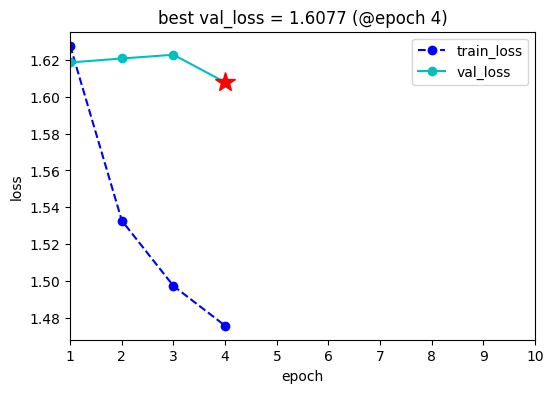

In [ ]:
dfhistory = keras_model.fit(
    train_data=train_dl,
    val_data=val_dl,
    epochs = cfg.epochs,
    monitor="val_loss",
    patience=20,
    mode='min',
    mixed_precision='fp16',
    ckpt_path=cfg.save_ckpt_path,
    gradient_accumulation_steps=cfg.gradient_accumulation_steps
)
dfhistory.to_csv(os.path.join(cfg.save_ckpt_path,"result.csv"))